In [4]:
import numpy as np
import os
import random
import csv
import collections
import math
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Bidirectional, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [5]:
train_path_bin = './DMD-2018-Data set/Task 1/training/training.xlsx'
train_path = './DMD-2018-Data set/Task-2/DGA-Train/train.csv'
df_train_bin = pd.read_excel(train_path_bin, index_col=None)
# Xóa các row có chứa nan
df_train_bin = df_train_bin.dropna()
print(df_train_bin.head())
df_train = pd.read_csv(train_path, index_col=None)
# Xóa các row có chứa nan
df_train = df_train.dropna()
print(df_train.head())


                         m644136d0.tmodns.net  0
0                                  dfg.ca.gov  0
1                c4w6wpg81xsbopy8a67.ddns.net  1
2                          ace.ojom-mobile.de  0
3  pub.3gppnetwork.org.mcdonaldswifi.internal  0
4                              cloudforge.com  0
   m8aoicy8qous.top  12
0    fiddlrxsat.com   4
1       verdzq.info  11
2  06cag28moasa.top  12
3    7liverpool.com   0
4  neodatagroup.com   0


In [6]:
X_test_bin_path = './DMD-2018-Data set/Task 1/testing/second testing/test2.txt'
y_test_bin_path = './DMD-2018-Data set/Task 1/testing/second testing/test2label.txt'
X_test_path = './DMD-2018-Data set/Task-2/DGA-Test/testing - 2/testing-2.txt'
y_test_path = './DMD-2018-Data set/Task-2/DGA-Test/testing - 2/testing-2-label.txt'

## BINARY-CLASS
# Đọc các domain từ test2.txt
with open(X_test_bin_path, 'r') as file:
    X_test_bin = file.readlines()
    X_test_bin = [line.strip() for line in X_test_bin]  # Loại bỏ khoảng trắng thừa

# Đọc các label từ test2label.txt
with open(y_test_bin_path, 'r') as file:
    y_test_bin = file.readlines()
    y_test_bin = [int(line.strip()) for line in y_test_bin]

# Kiểm tra kết quả
print("Domains:", X_test_bin[:5])
print("Labels:", y_test_bin[:5])

## MULTI-CLASS
# Đọc các domain từ testing-2.txt
with open(X_test_path, 'r') as file:
    X_test = file.readlines()
    X_test = [line.strip() for line in X_test]  # Loại bỏ khoảng trắng thừa

# Đọc các label từ testing-2-label.txt
with open(y_test_path, 'r') as file:
    y_test = file.readlines()
    y_test = [int(line.strip()) for line in y_test]

# Kiểm tra kết quả
print("Domains:", X_test[:5])
print("Labels:", y_test[:5])


Domains: ['9248c26a0be23c01.net', 'ytubeukhylbhqwsbmbifmiblmbx.info', 'zidnwnki.org', 'qbfnof.dyndns.org', '1uzfyzf5xo7ux1y4czth1pfq856.net']
Labels: [1, 1, 1, 1, 1]
Domains: ['api.watchstadium.com', 'jaunhbjoxi.com', 'elelg850k4qdgf5x7lgvoxy.ddns.net', 'zgh2nw9azopm.com', 'klhjaqzsma.com']
Labels: [0, 4, 2, 12, 4]


In [7]:
# Chia dữ liệu trong df_train_bin thành features và labels
X_train_bin = df_train_bin.iloc[:, 0]  # Lấy dữ liệu từ cột đầu tiên
y_train_bin = df_train_bin.iloc[:, 1]  # Lấy dữ liệu từ cột thứ hai

# Chia dữ liệu trong df_train thành features và labels
X_train = df_train.iloc[:, 0]  # Lấy dữ liệu từ cột đầu tiên
y_train = df_train.iloc[:, 1]  # Lấy dữ liệu từ cột thứ hai

print(y_train_bin.info())
print(y_train.info())

<class 'pandas.core.series.Series'>
RangeIndex: 790738 entries, 0 to 790737
Series name: 0
Non-Null Count   Dtype
--------------   -----
790738 non-null  int64
dtypes: int64(1)
memory usage: 6.0 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 397776 entries, 0 to 397775
Series name: 12
Non-Null Count   Dtype
--------------   -----
397776 non-null  int64
dtypes: int64(1)
memory usage: 3.0 MB
None


In [8]:
# Tat ca features:
X = X_train.tolist() + X_train_bin.tolist() + X_test + X_test_bin
X[:10]

['fiddlrxsat.com',
 'verdzq.info',
 '06cag28moasa.top',
 '7liverpool.com',
 'neodatagroup.com',
 'oonsvfskdcwnv.net',
 'aniways.blob.core.windows.net',
 'orleifeduxgeqfieicyrkibypcetk.ru',
 'aqhizhcuhqvwpnovhwowobmqaqgy.biz',
 'efkkkbcecbocdbaa.org']

In [9]:
# Tạo dictionary, ánh xạ mỗi kí tự sang 1 số nguyên
valid_chars = {x: idx + 1 for idx, x in enumerate(set(''.join([str(domain) for domain in X])))}

max_features = len(valid_chars) + 1
maxlen = np.max([len(str(x)) for x in X])

In [10]:
# Ánh xạ và padding
X_train = [[valid_chars[y] for y in str(x)] for x in X_train.tolist()]
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_train_bin = [[valid_chars[y] for y in str(x)] for x in X_train_bin.tolist()]
X_train_bin = sequence.pad_sequences(X_train_bin, maxlen=maxlen)

X_test = [[valid_chars[y] for y in str(x)] for x in X_test]
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
X_test_bin = [[valid_chars[y] for y in str(x)] for x in X_test_bin]
X_test_bin = sequence.pad_sequences(X_test_bin, maxlen=maxlen)

In [11]:
# Đếm số lượng mỗi label trong y_train và y_test
count_train = collections.Counter(y_train)
count_test = collections.Counter(y_test)

print("Số lượng trong y_train:")
for key in sorted(count_train):
    print(f"Label {key}: {count_train[key]} mẫu")
print('-------------------------------------------')
print("Số lượng trong y_test:")
for key in sorted(count_test):
    print(f"Label {key}: {count_train[key]} mẫu")

Số lượng trong y_train:
Label 0: 100000 mẫu
Label 1: 15000 mẫu
Label 2: 15000 mẫu
Label 3: 15000 mẫu
Label 4: 15000 mẫu
Label 5: 15000 mẫu
Label 6: 15000 mẫu
Label 7: 12777 mẫu
Label 8: 15000 mẫu
Label 9: 15000 mẫu
Label 10: 15000 mẫu
Label 11: 15000 mẫu
Label 12: 14999 mẫu
Label 13: 15000 mẫu
Label 14: 15000 mẫu
Label 15: 15000 mẫu
Label 16: 15000 mẫu
Label 17: 15000 mẫu
Label 18: 15000 mẫu
Label 19: 15000 mẫu
Label 20: 15000 mẫu
-------------------------------------------
Số lượng trong y_test:
Label 0: 100000 mẫu
Label 1: 15000 mẫu
Label 2: 15000 mẫu
Label 3: 15000 mẫu
Label 4: 15000 mẫu
Label 5: 15000 mẫu
Label 6: 15000 mẫu
Label 7: 12777 mẫu
Label 8: 15000 mẫu
Label 9: 15000 mẫu
Label 10: 15000 mẫu
Label 11: 15000 mẫu
Label 12: 14999 mẫu
Label 13: 15000 mẫu
Label 14: 15000 mẫu
Label 15: 15000 mẫu
Label 16: 15000 mẫu
Label 17: 15000 mẫu
Label 18: 15000 mẫu
Label 19: 15000 mẫu
Label 20: 15000 mẫu


In [12]:
def build_binary_model(max_features, maxlen):
    """Build LSTM model for two-class classification using Bi-LSTM"""
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=maxlen))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop')

    return model

def build_multiclass_model(max_features, maxlen):
    """Build multiclass LSTM model for multiclass classification using Bi-LSTM"""
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=maxlen))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(21))  # Có 21 loại
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

    return model

In [13]:
def create_class_weight(labels_dict, mu):
    """Create weight based on the number of domain name in the dataset"""
    total = np.sum(list(labels_dict.values()))
    class_weight = dict()

    for key in labels_dict.keys():
        # Calculate the class weight using the provided formula
        score = math.pow(total / float(labels_dict[key]), mu)
        class_weight[key] = score

    return class_weight

In [14]:
y_test_bin = np.array(y_test_bin)
y_test = np.array(y_test)

In [15]:
print(X_train_bin.shape)
print(y_train_bin.shape)
print(X_test_bin.shape)
print(y_test_bin.shape)
print('---------------')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(790738, 196)
(790738,)
(2922, 196)
(2922,)
---------------
(397776, 196)
(397776,)
(103200, 196)
(103200,)


In [16]:
# Tạo model
binary_model = build_binary_model(max_features, maxlen)
model = build_multiclass_model(max_features, maxlen)

In [17]:
EPOCHS = 20

In [18]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_type='binary'):
    # Tính các chỉ số đánh giá
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary' if model_type == 'binary' else 'macro')
    rec = recall_score(y_true, y_pred, average='binary' if model_type == 'binary' else 'macro')
    f1 = f1_score(y_true, y_pred, average='binary' if model_type == 'binary' else 'macro')

    # In các chỉ số
    print(f"Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    print(f"F1 Score: {f1}")

    # Vẽ đường cong ROC và tính AUC
    if model_type == 'binary':
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
    elif model_type == 'multiclass':
        # Tính AUC cho phân loại đa lớp
        roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')

    plt.figure()
    if model_type == 'binary':
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    elif model_type == 'multiclass':
        # Không vẽ đường cong ROC cho phân loại đa lớp ở đây
        plt.title('Multiclass classification - ROC AUC provided')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return acc, prec, rec, f1, roc_auc

In [19]:
# BINARY-CLASS

# Train
labels_dict=collections.Counter(y_train_bin)
class_weight = create_class_weight(labels_dict, 0.1)
binary_model.fit(X_train_bin, y_train_bin, batch_size=128, epochs=1, class_weight=class_weight)

y_pred_bin_probs = binary_model.predict(X_test_bin)
print(y_pred_bin_probs[:5])

92/92 [==============================] - 11s 107ms/step
[[0.29507813]
 [0.98267037]
 [0.9338382 ]
 [0.9964258 ]
 [0.9954341 ]]


In [20]:

y_pred_bin = [0 if(x<=0.5) else 1 for x in y_pred_bin_probs]

Accuracy: 0.7501711156741958
Precision: 0.9995029821073559
Recall: 0.733941605839416
F1 Score: 0.8463804713804713


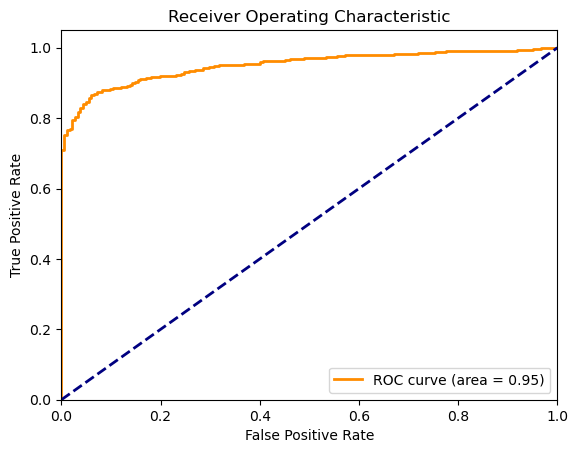

(0.7501711156741958,
 0.9995029821073559,
 0.733941605839416,
 0.8463804713804713,
 0.9502927729205102)

In [21]:
# Đánh giá
evaluate_model(y_test_bin, y_pred_bin, y_pred_bin_probs, model_type='binary')

In [22]:
# MULTI-CLASS

# Train             
labels_dict=collections.Counter(y_train)
class_weight = create_class_weight(labels_dict, 0.1)
model.fit(X_train, y_train, batch_size=128, epochs=1, class_weight=class_weight)

y_pred_proba= model.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred_proba]

3225/3225 [==============================] - 355s 110ms/step


Accuracy: 0.6559205426356589
Precision: 0.46537777897165145
Recall: 0.5627540076105243
F1 Score: 0.46509967128779617


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


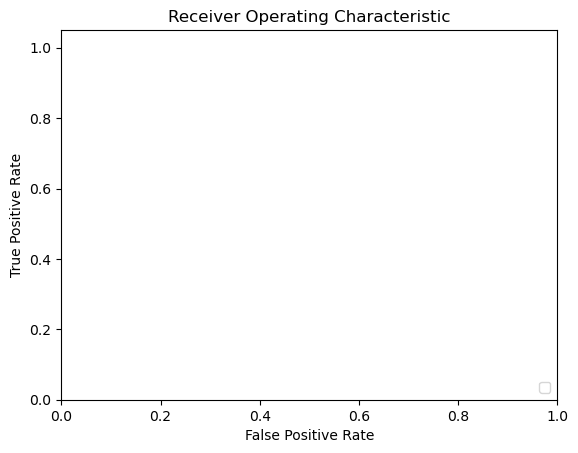

(0.6559205426356589,
 0.46537777897165145,
 0.5627540076105243,
 0.46509967128779617,
 0.9309938609996783)

In [23]:
# Đánh giá
evaluate_model(y_test, y_pred, y_pred_proba, model_type='multiclass')